<a href="https://colab.research.google.com/github/nzelinska-job/dengai-predicting-disease-spread/blob/main/dengue_benchmark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline

from __future__ import print_function
from __future__ import division

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import statsmodels.api as sm

# just for the sake of this blog post!
from warnings import filterwarnings

filterwarnings("ignore")

A Tale of Two Cities

This dataset has two cities in it: San Juan, Puerto Rico (right) and Iquitos, Peru (left). Since we hypothesize that the spread of dengue may follow different patterns between the two, we will divide the dataset, train seperate models for each city, and then join our predictions before making our final submission.

In [ ]:
# load the provided data
train_features = pd.read_csv(
    "sample_data/data-processed/dengue_features_train.csv", index_col=[0, 1, 2]
)

train_labels = pd.read_csv(
    "sample_data/data-processed/dengue_labels_train.csv", index_col=[0, 1, 2]
)

In [ ]:
# Seperate data for San Juan
sj_train_features = train_features.loc["sj"]
sj_train_labels = train_labels.loc["sj"]

# Separate data for Iquitos
iq_train_features = train_features.loc["iq"]
iq_train_labels = train_labels.loc["iq"]

In [ ]:
print("San Juan")
print("features: ", sj_train_features.shape)
print("labels  : ", sj_train_labels.shape)

print("\nIquitos")
print("features: ", iq_train_features.shape)
print("labels  : ", iq_train_labels.shape)

San Juan
features:  (936, 21)
labels  :  (936, 1)

Iquitos
features:  (520, 21)
labels  :  (520, 1)


In [ ]:
sj_train_features.head()

week_start_date   ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  \
year weekofyear                                                           
1990 18              1990-04-30  0.122600  0.103725  0.198483  0.177617   
     19              1990-05-07  0.169900  0.142175  0.162357  0.155486   
     20              1990-05-14  0.032250  0.172967  0.157200  0.170843   
     21              1990-05-21  0.128633  0.245067  0.227557  0.235886   
     22              1990-05-28  0.196200  0.262200  0.251200  0.247340   

                 precipitation_amt_mm  reanalysis_air_temp_k  \
year weekofyear                                                
1990 18                         12.42             297.572857   
     19                         22.82             298.211429   
     20                         34.54             298.781429   
     21                         15.36             298.987143   
     22                          7.52             299.518571   

                 reanalysis_avg_temp_k  reanalysis_dew_point_temp_k  \
year weekofyear                                                       
1990 18                     297.742857                   292.414286   
     19                     298.442857                   293.951429   
     20                     298.878571                   295.434286   
     21                     299.228571                   295.310000   
     22                     299.664286                   295.821429   

                 reanalysis_max_air_temp_k  ...  \
year weekofyear                             ...   
1990 18                              299.8  ...   
     19                              300.9  ...   
     20                              300.5  ...   
     21                              301.4  ...   
     22                              301.9  ...   

                 reanalysis_precip_amt_kg_per_m2  \
year weekofyear                                    
1990 18                                    32.00   
     19                                    17.94   
     20                                    26.10   
     21                                    13.90   
     22                                    12.20   

                 reanalysis_relative_humidity_percent  \
year weekofyear                                         
1990 18                                     73.365714   
     19                                     77.368571   
     20                                     82.052857   
     21                                     80.337143   
     22                                     80.460000   

                 reanalysis_sat_precip_amt_mm  \
year weekofyear                                 
1990 18                                 12.42   
     19                                 22.82   
     20                                 34.54   
     21                                 15.36   
     22                                  7.52   

                 reanalysis_specific_humidity_g_per_kg  reanalysis_tdtr_k  \
year weekofyear                                                             
1990 18                                      14.012857           2.628571   
     19                                      15.372857           2.371429   
     20                                      16.848571           2.300000   
     21                                      16.672857           2.428571   
     22                                      17.210000           3.014286   

                 station_avg_temp_c  station_diur_temp_rng_c  \
year weekofyear                                                
1990 18                   25.442857                 6.900000   
     19                   26.714286                 6.371429   
     20                   26.714286                 6.485714   
     21                   27.471429                 6.771429   
     22                   28.942857                 9.371429   

                 station_max_temp_c  station_min_temp_c  station_precip_mm  
year weeko

In [ ]:
# Remove `week_start_date` string.
sj_train_features.drop("week_start_date", axis=1, inplace=True)
iq_train_features.drop("week_start_date", axis=1, inplace=True)

In [ ]:
# Null check
pd.isnull(sj_train_features).any()

,0
ndvi_ne,True
ndvi_nw,True
ndvi_se,True
ndvi_sw,True
precipitation_amt_mm,True
reanalysis_air_temp_k,True
reanalysis_avg_temp_k,True
reanalysis_dew_point_temp_k,True
reanalysis_max_air_temp_k,True
reanalysis_min_air_temp_k,True


Text(0.5, 0, 'Time')

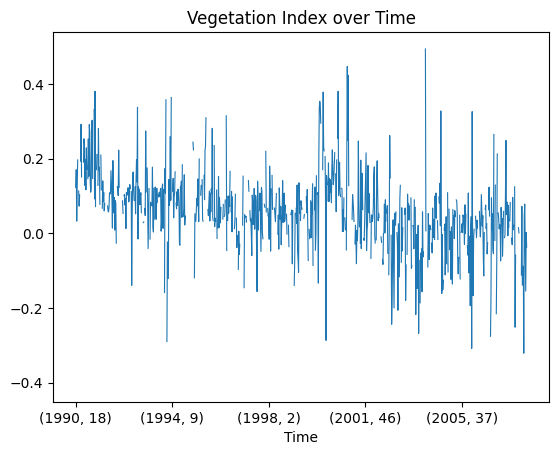

In [ ]:
(sj_train_features.ndvi_ne.plot.line(lw=0.8))

plt.title("Vegetation Index over Time")
plt.xlabel("Time")

In [ ]:
sj_train_features.fillna(method="ffill", inplace=True)
iq_train_features.fillna(method="ffill", inplace=True)

In [ ]:
print("San Juan")
print("mean: ", sj_train_labels.mean()[0])
print("var :", sj_train_labels.var()[0])

print("\nIquitos")
print("mean: ", iq_train_labels.mean()[0])
print("var :", iq_train_labels.var()[0])

San Juan
mean:  34.18055555555556
var : 2640.045439691045

Iquitos
mean:  7.565384615384615
var : 115.8955239365642


array([[<Axes: title={'center': 'total_cases'}>]], dtype=object)

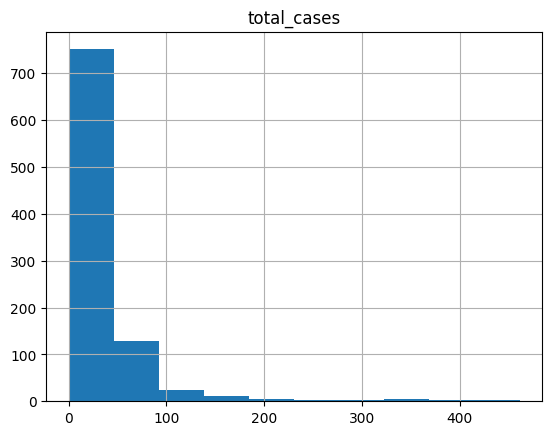

In [ ]:
sj_train_labels.hist()

array([[<Axes: title={'center': 'total_cases'}>]], dtype=object)

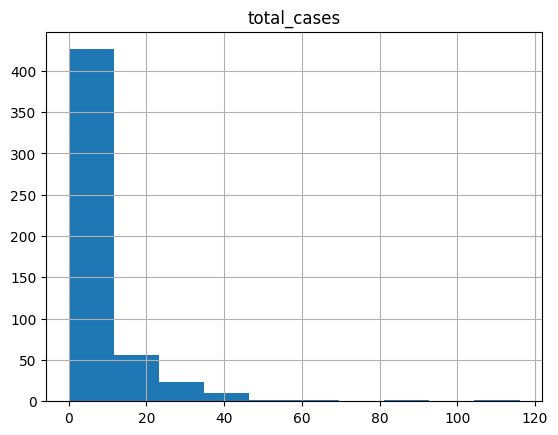

In [ ]:
iq_train_labels.hist()

In [ ]:
sj_train_features["total_cases"] = sj_train_labels.total_cases
iq_train_features["total_cases"] = iq_train_labels.total_cases

In [ ]:
# compute the correlations
sj_correlations = sj_train_features.corr()
iq_correlations = iq_train_features.corr()

Text(0.5, 1.0, 'San Juan Variable Correlations')

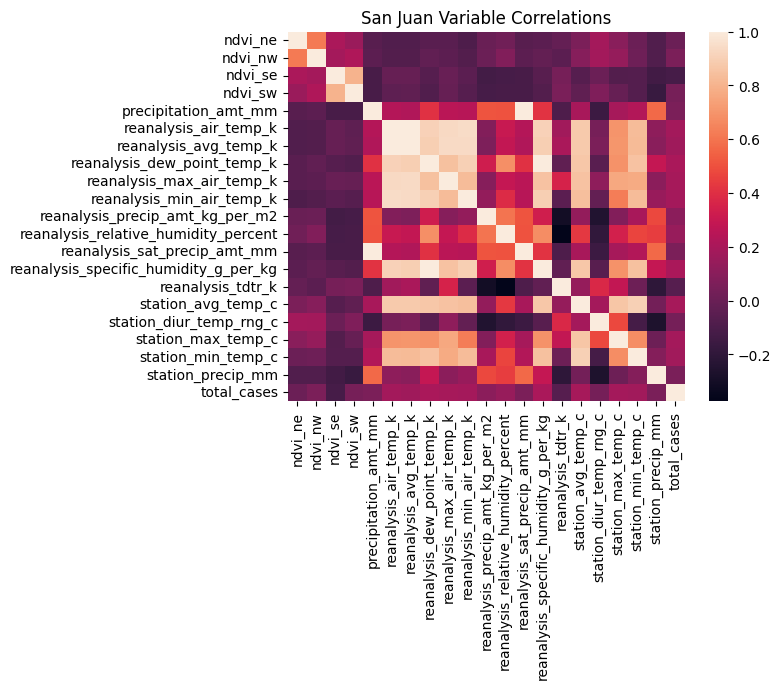

In [ ]:
# plot san juan
sj_corr_heat = sns.heatmap(sj_correlations)
plt.title("San Juan Variable Correlations")

Text(0.5, 1.0, 'Iquitos Variable Correlations')

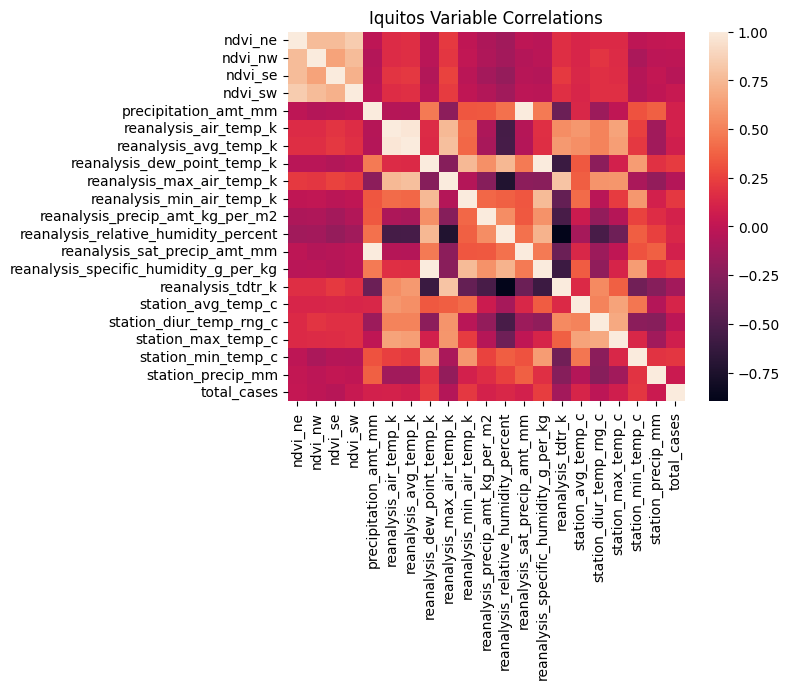

In [ ]:
# plot iquitos
iq_corr_heat = sns.heatmap(iq_correlations)
plt.title("Iquitos Variable Correlations")

<Axes: >

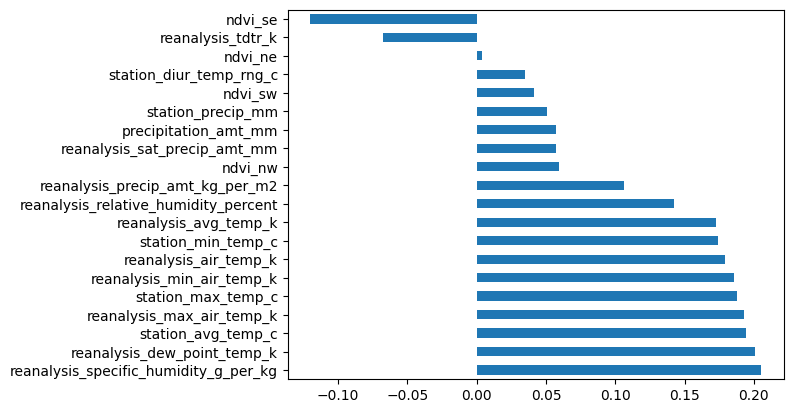

In [ ]:
# San Juan
(
    sj_correlations.total_cases.drop("total_cases")  # don't compare with myself
    .sort_values(ascending=False)
    .plot.barh()
)

<Axes: >

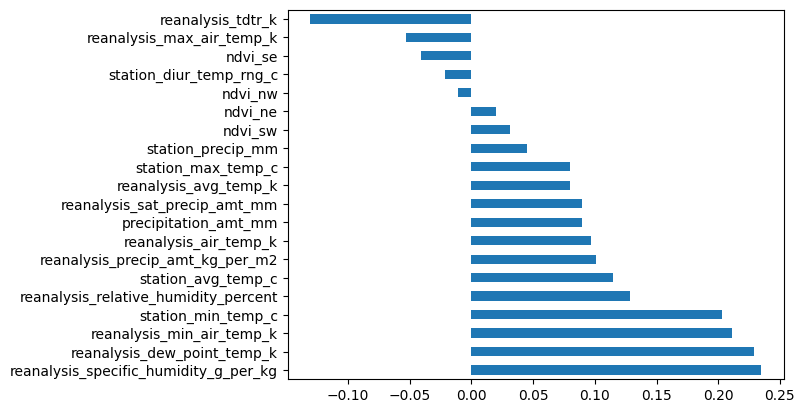

In [ ]:
# Iquitos
(
    iq_correlations.total_cases.drop("total_cases")  # don't compare with myself
    .sort_values(ascending=False)
    .plot.barh()
)

In [ ]:
def preprocess_data(data_path, labels_path=None):
    # load data and set index to city, year, weekofyear
    df = pd.read_csv(data_path, index_col=[0, 1, 2])

    # select features we want
    features = [
        "reanalysis_specific_humidity_g_per_kg",
        "reanalysis_dew_point_temp_k",
        "station_avg_temp_c",
        "station_min_temp_c",
    ]
    df = df[features]

    # fill missing values
    df.fillna(method="ffill", inplace=True)

    # add labels to dataframe
    if labels_path:
        labels = pd.read_csv(labels_path, index_col=[0, 1, 2])
        df = df.join(labels)

    # separate san juan and iquitos
    sj = df.loc["sj"]
    iq = df.loc["iq"]

    return sj, iq

In [ ]:
sj_train, iq_train = preprocess_data(
    "sample_data/data-processed/dengue_features_train.csv",
    labels_path="sample_data/data-processed/dengue_labels_train.csv",
)

In [ ]:
sj_train.describe()

,reanalysis_specific_humidity_g_per_kg,reanalysis_dew_point_temp_k,station_avg_temp_c,station_min_temp_c,total_cases
count,936.000000,936.000000,936.000000,936.000000,936.000000
mean,16.547535,295.104736,26.999191,22.594017,34.180556
std,1.560663,1.570075,1.415079,1.506281,51.381372
min,11.715714,289.642857,22.842857,17.800000,0.000000
25%,15.233571,293.843929,25.842857,21.700000,9.000000
50%,16.835000,295.451429,27.214286,22.800000,19.000000
75%,17.854286,296.415714,28.175000,23.900000,37.000000
max,19.440000,297.795714,30.071429,25.600000,461.000000


In [ ]:
iq_train.describe()

,reanalysis_specific_humidity_g_per_kg,reanalysis_dew_point_temp_k,station_avg_temp_c,station_min_temp_c,total_cases
count,520.000000,520.000000,520.000000,520.000000,520.000000
mean,17.102019,295.498723,27.506331,21.210385,7.565385
std,1.443048,1.414360,0.908973,1.257734,10.765478
min,12.111429,290.088571,21.400000,14.700000,0.000000
25%,16.121429,294.596429,26.957500,20.600000,1.000000
50%,17.428571,295.852143,27.587500,21.400000,5.000000
75%,18.180357,296.557143,28.075000,22.000000,9.000000
max,20.461429,298.450000,30.800000,24.200000,116.000000


# Split it up!

In [ ]:
sj_train_subtrain = sj_train.head(800)
sj_train_subtest = sj_train.tail(sj_train.shape[0] - 800)

iq_train_subtrain = iq_train.head(400)
iq_train_subtest = iq_train.tail(iq_train.shape[0] - 400)